<a href="https://colab.research.google.com/github/LisaStrsh/ProcessMining/blob/main/CourseWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download tables and general information

In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

!apt-get install graphviz libgraphviz-dev
!pip install pygraphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.




---



### Recruitment process log

In [ ]:
hr = pd.read_excel('HR_log_obezlich.xlsx', engine='openpyxl')
hr.head()

,case_id,line_id,from,to,time
0,1,1,Новый,Рассмотрение заказчиком,184.081136
1,1,2,Рассмотрение заказчиком,Оценка кандидата,216.771912
2,1,3,Оценка кандидата,Отклонен,222.700654
3,2,1,Новый,Рассмотрение заказчиком,528.787113
4,2,2,Рассмотрение заказчиком,Интервью,104.049962


In [ ]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5288 entries, 0 to 5287
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   case_id  5288 non-null   int64  
 1   line_id  5288 non-null   int64  
 2   from     5288 non-null   object 
 3   to       5288 non-null   object 
 4   time     5288 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 206.7+ KB


Check for records that do not start with the step "Новый"

In [ ]:
first_steps = hr.sort_values('line_id').groupby('case_id').first().reset_index()
not_new_cases = first_steps[first_steps['from'] != 'Новый'][['case_id', 'from']]

if not_new_cases.empty:
    print("No records")
else:
    print("Records: ")


No records


Steps that do not end on "Отклонен", "Оформлен"

In [ ]:
last_steps = hr.sort_values('line_id').groupby('case_id').last().reset_index()
not_expected_final_cases = last_steps[~last_steps['to'].isin(['Оформлен', 'Отклонен', 'Резерв'])][['case_id', 'to']]

if not_expected_final_cases.empty:
    print("No records")
else:
    print("Records: ")



No records


### Dictionary of recruitment process log

In [ ]:
dic = pd.read_excel('Dict_hr.xlsx', engine='openpyxl')
dic.head()

,from,to,min,max,avg
0,Самоотказ,Отклонен,1.000000,336,93.415151
1,Отклонен,Отклонен,0.000278,1,0.258403
2,Не выходит на связь,Отклонен,1.000000,730,196.259256
3,Резерв,Отклонен,168.000000,8760,2838.564094
4,Готов к переводу,Отклонен,0.000278,336,84.152822


In [ ]:
dic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   from    54 non-null     object 
 1   to      54 non-null     object 
 2   min     54 non-null     float64
 3   max     54 non-null     int64  
 4   avg     54 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.2+ KB




---



# Process Mining Manual for Process Analysis

## 1. Analyse the current state of business

### a. General graph showing how the process is running at the moment

<ipython-input-45-f9b1bb2dd9a2>:31: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



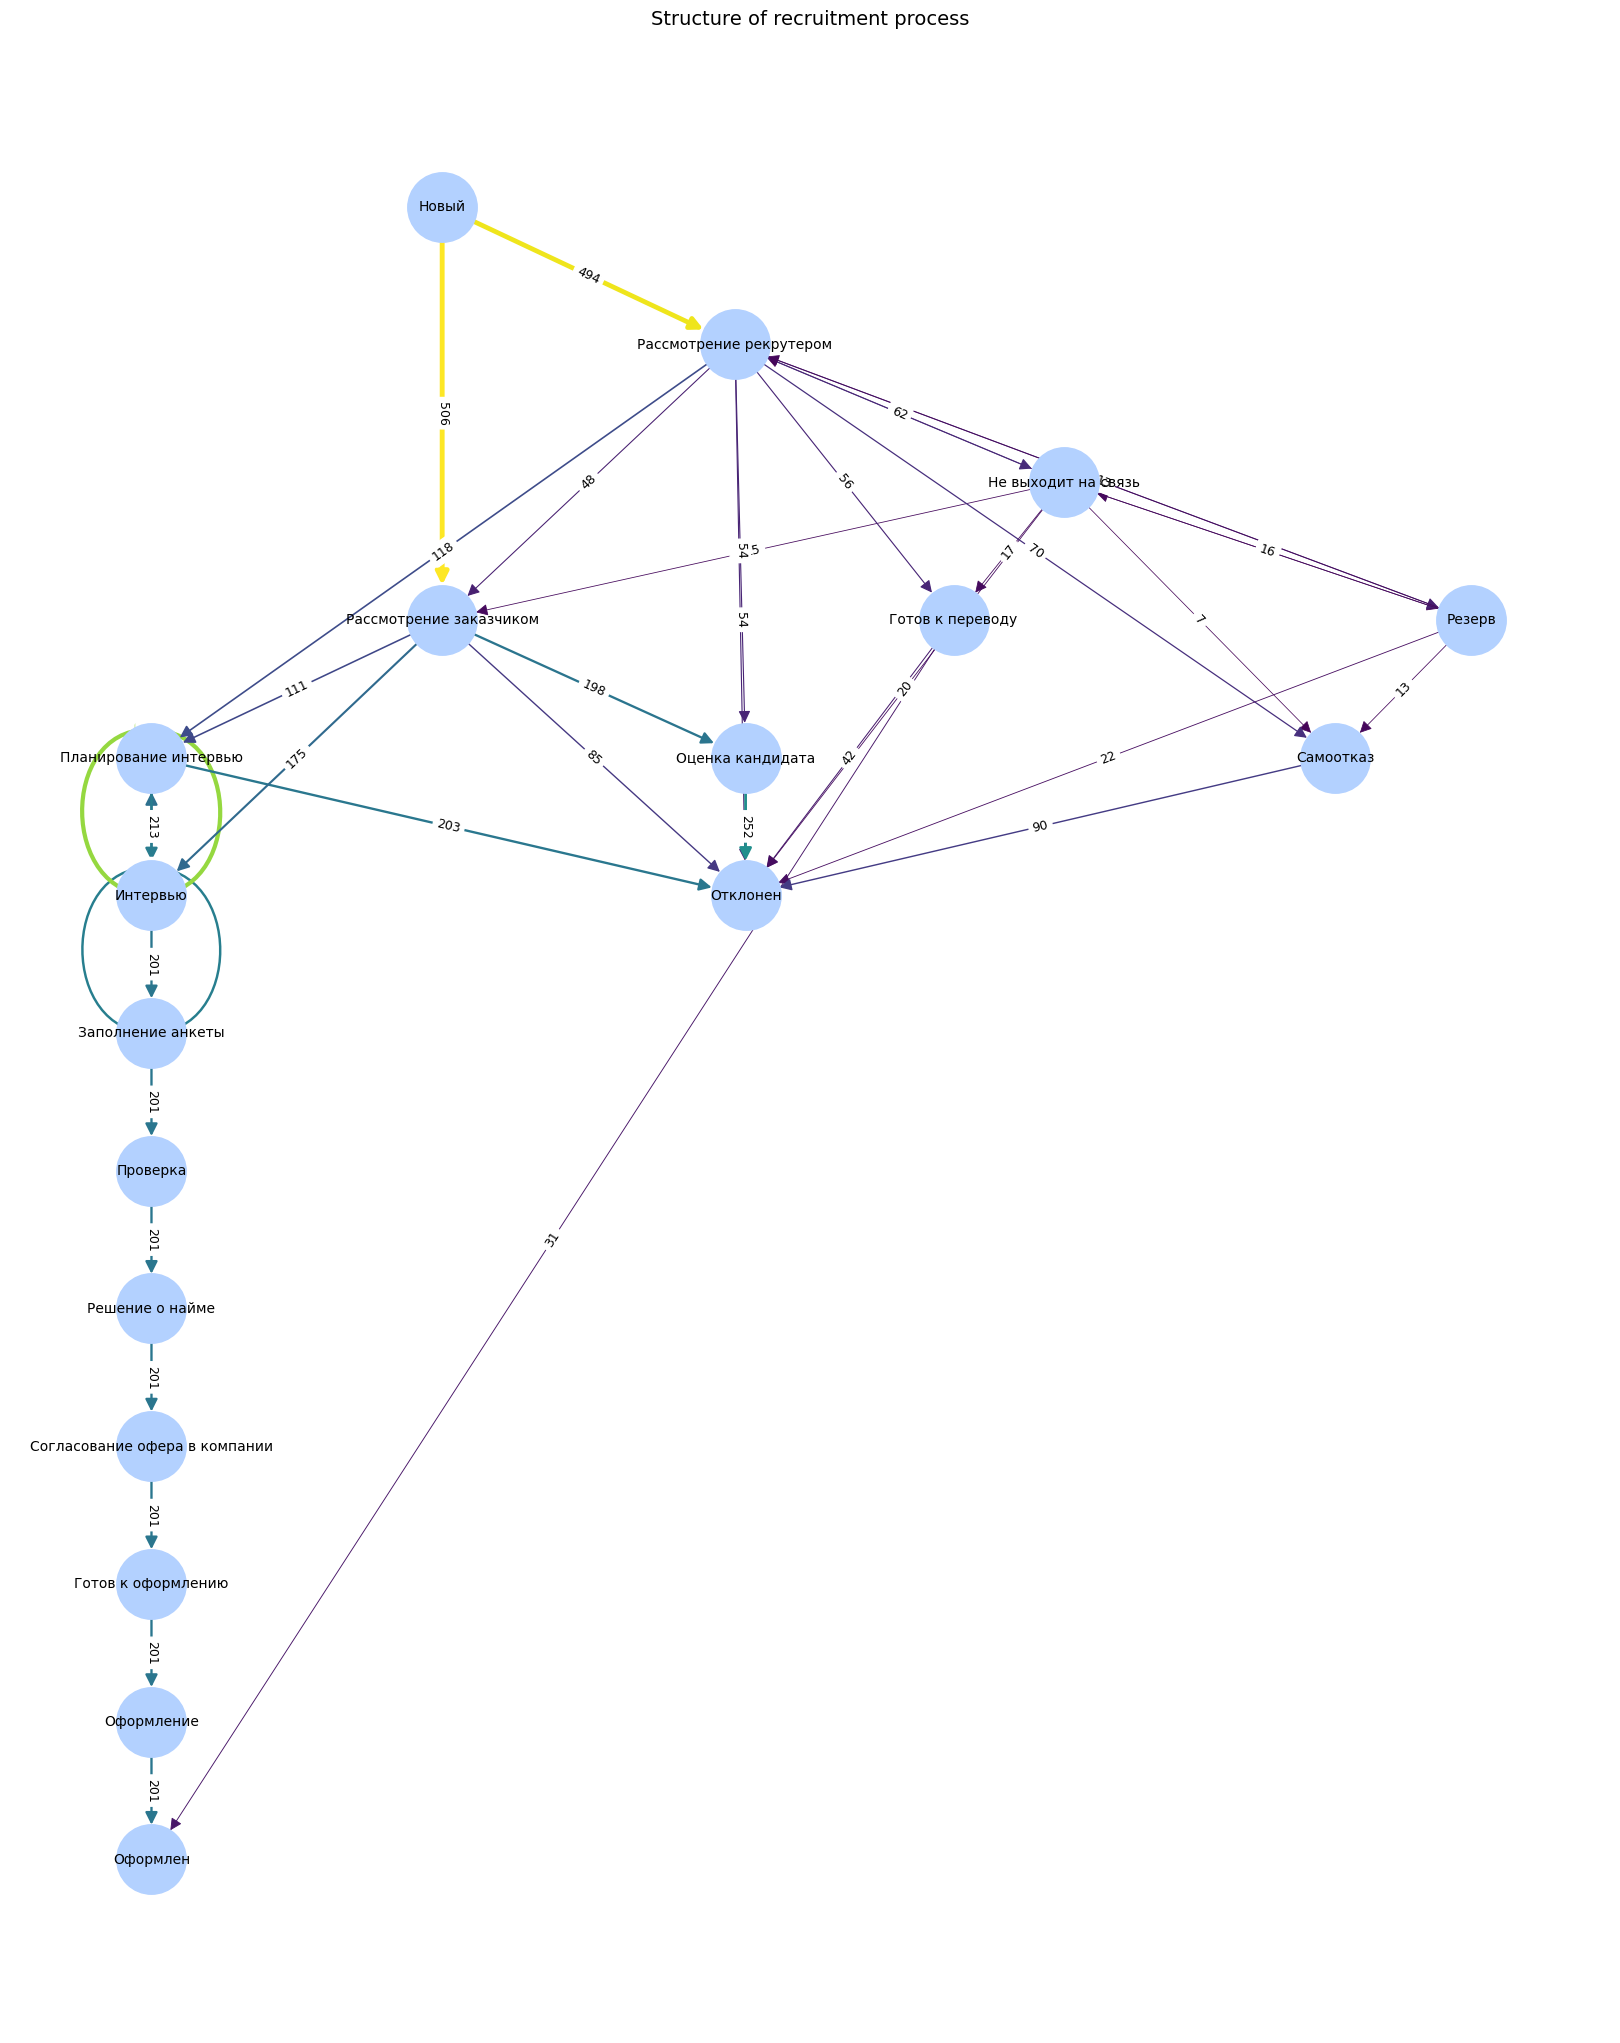

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout

trans_counts = hr.groupby(['from', 'to']).size().reset_index(name='count')
G = nx.DiGraph()
for _, row in trans_counts.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['count'])
pos = graphviz_layout(G, prog='dot')

plt.figure(figsize=(16, 20))
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
norm_weights = (np.array(weights) - np.min(weights)) / (np.max(weights) - np.min(weights)) * 3 + 0.5

nx.draw(G, pos,
        with_labels=True,
        node_size=2500,
        node_color='#B3D1FF',
        font_size=10,
        edge_color=norm_weights,
        width=norm_weights,
        edge_cmap=plt.cm.viridis,
        arrowsize=18)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)},
    font_size=9
)

plt.title("Structure of recruitment process", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


## 2.Find out how many people pass and don’t pass interviews. Propose process optimization to hire and reject 50 50


Check for the presence of records that end in the reserve phase:

In [ ]:
last_steps = hr.sort_values('line_id').groupby('case_id').last().reset_index()
reserve_cases = last_steps[last_steps['to'] == 'Резерв'][['case_id', 'to']]

if reserve_cases.empty:
    print("No records")
else:
    print("records: ")


No records


### How many people have reached the stage “Оформлен” and “Отклонен”

In [ ]:
import plotly.express as px

last_steps = hr.loc[hr.groupby('case_id')['line_id'].idxmax()]
last_steps = last_steps[['case_id', 'from', 'to']]
last_steps['final'] = last_steps['to']
last_steps['prev'] = last_steps['from']

counts = last_steps.groupby(['final', 'prev']).size().reset_index(name='count')

fig = px.sunburst(
    counts,
    path=['final', 'prev'],
    values='count',
    color='final',
    color_discrete_map={'Отклонен': '#FF4500', 'Оформлен': '#9ACD32'},
    title='Ratio of rejected and accepted canditates'
)

fig.update_traces(textinfo="label+percent entry")
fig.show()


### 2.b. The most common development paths in “Оформлен” and “Отклонен”

То The 10 most common ways of driving from "Новый" to "Принят"

<ipython-input-35-274d8e928948>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-35-274d8e928948>:18: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



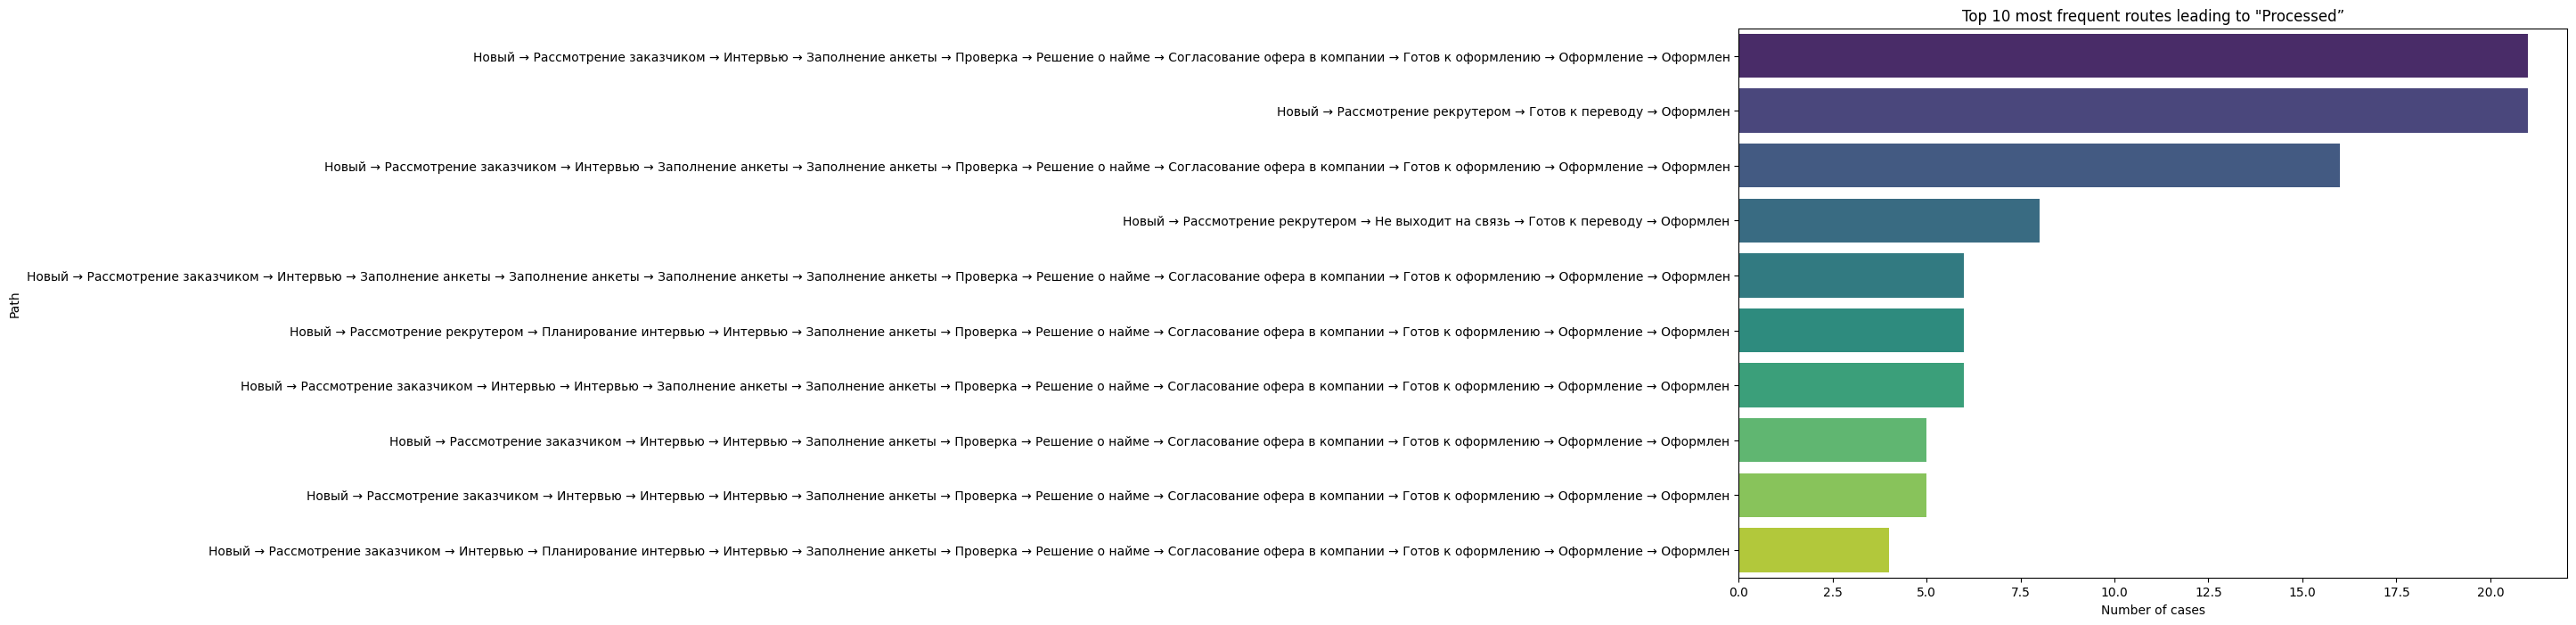

,path,count
0,Новый → Рассмотрение заказчиком → Интервью → З...,21
1,Новый → Рассмотрение рекрутером → Готов к пере...,21
2,Новый → Рассмотрение заказчиком → Интервью → З...,16
3,Новый → Рассмотрение рекрутером → Не выходит н...,8
4,Новый → Рассмотрение заказчиком → Интервью → З...,6
5,Новый → Рассмотрение рекрутером → Планирование...,6
6,Новый → Рассмотрение заказчиком → Интервью → И...,6
7,Новый → Рассмотрение заказчиком → Интервью → И...,5
8,Новый → Рассмотрение заказчиком → Интервью → И...,5
9,Новый → Рассмотрение заказчиком → Интервью → П...,4


In [ ]:
paths_df = hr.groupby('case_id')['from'].apply(list).reset_index()
paths_df['final'] = hr.groupby('case_id')['to'].last().values

paths_df['full_path'] = paths_df.apply(lambda row: row['from'] + [row['final']], axis=1)
paths_df['path_str'] = paths_df['full_path'].apply(lambda x: ' → '.join(x))

success_paths = paths_df[paths_df['final'] == 'Оформлен']
success_path_counts = success_paths['path_str'].value_counts().reset_index()
success_path_counts.columns = ['path', 'count']

top_success_paths = success_path_counts.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_success_paths, y='path', x='count', palette='viridis')
plt.title('Top 10 most frequent routes leading to "Processed”')
plt.xlabel('Number of cases')
plt.ylabel('Path')
plt.tight_layout()
plt.show()

top_success_paths

Top 10 most popular driving routes from "Новый" to "Отклонен"




<ipython-input-36-3cbb1661076f>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




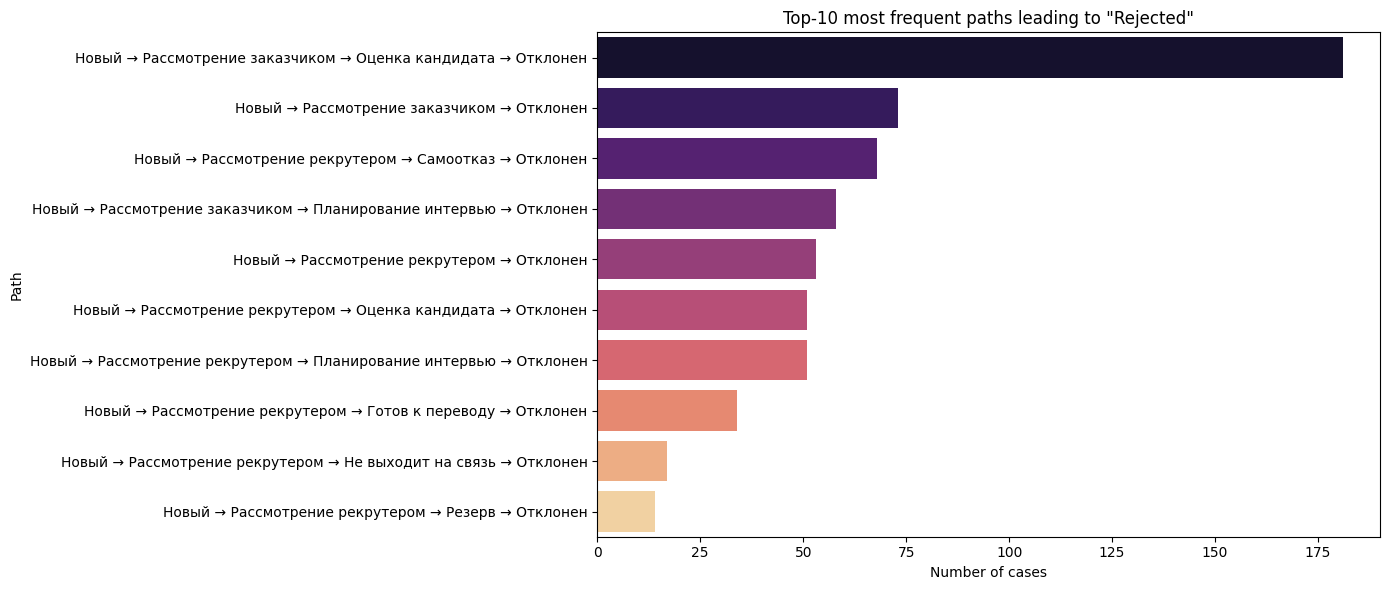

,path,count
0,Новый → Рассмотрение заказчиком → Оценка канди...,181
1,Новый → Рассмотрение заказчиком → Отклонен,73
2,Новый → Рассмотрение рекрутером → Самоотказ → ...,68
3,Новый → Рассмотрение заказчиком → Планирование...,58
4,Новый → Рассмотрение рекрутером → Отклонен,53
5,Новый → Рассмотрение рекрутером → Оценка канди...,51
6,Новый → Рассмотрение рекрутером → Планирование...,51
7,Новый → Рассмотрение рекрутером → Готов к пере...,34
8,Новый → Рассмотрение рекрутером → Не выходит н...,17
9,Новый → Рассмотрение рекрутером → Резерв → Отк...,14


In [ ]:
paths_df = hr.groupby('case_id')['from'].apply(list).reset_index()
paths_df['final'] = hr.groupby('case_id')['to'].last().values

paths_df['full_path'] = paths_df.apply(lambda row: row['from'] + [row['final']], axis=1)
paths_df['path_str'] = paths_df['full_path'].apply(lambda x: ' → '.join(x))
reject_paths = paths_df[paths_df['final'] == 'Отклонен']

reject_path_counts = reject_paths['path_str'].value_counts().reset_index()
reject_path_counts.columns = ['path', 'count']

top_reject_paths = reject_path_counts.head(10)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_reject_paths, y='path', x='count', palette='magma')
plt.title('Top-10 most frequent paths leading to "Rejected"')
plt.xlabel('Number of cases')
plt.ylabel('Path')
plt.tight_layout()
plt.show()

top_reject_paths



The rarest development paths in “Оформлен”

In [ ]:
paths_df = hr.groupby('case_id')['from'].apply(list).reset_index()
paths_df['final'] = hr.groupby('case_id')['to'].last().values

paths_df['full_path'] = paths_df.apply(lambda row: row['from'] + [row['final']], axis=1)
paths_df['path_str'] = paths_df['full_path'].apply(lambda x: ' → '.join(x))

success_paths = paths_df[paths_df['final'] == 'Оформлен']

success_path_counts = success_paths['path_str'].value_counts().reset_index()
success_path_counts.columns = ['path', 'count']

rare_success_paths = success_path_counts[success_path_counts['count'] == 1]

rare_success_paths = rare_success_paths.reset_index(drop=True)
rare_success_paths

,path,count
0,Новый → Рассмотрение рекрутером → Планирование...,1
1,Новый → Рассмотрение заказчиком → Планирование...,1
2,Новый → Рассмотрение рекрутером → Планирование...,1
3,Новый → Рассмотрение рекрутером → Планирование...,1
4,Новый → Рассмотрение рекрутером → Планирование...,1
...,...,...
84,Новый → Рассмотрение заказчиком → Интервью → И...,1
85,Новый → Рассмотрение заказчиком → Планирование...,1
86,Новый → Рассмотрение заказчиком → Интервью → И...,1
87,Новый → Рассмотрение заказчиком → Интервью → И...,1


The rarest development paths in “Отклонен”

In [ ]:
paths_df = hr.groupby('case_id')['from'].apply(list).reset_index()
paths_df['final'] = hr.groupby('case_id')['to'].last().values

paths_df['full_path'] = paths_df.apply(lambda row: row['from'] + [row['final']], axis=1)
paths_df['path_str'] = paths_df['full_path'].apply(lambda x: ' → '.join(x))
reject_paths = paths_df[paths_df['final'] == 'Отклонен']

reject_path_counts = reject_paths['path_str'].value_counts().reset_index()
reject_path_counts.columns = ['path', 'count']

rare_reject_paths = reject_path_counts[reject_path_counts['count'] == 1]

rare_reject_paths = rare_reject_paths.reset_index(drop=True)
rare_reject_paths

,path,count
0,Новый → Рассмотрение рекрутером → Не выходит н...,1
1,Новый → Рассмотрение заказчиком → Интервью → И...,1
2,Новый → Рассмотрение рекрутером → Планирование...,1
3,Новый → Рассмотрение рекрутером → Рассмотрение...,1
4,Новый → Рассмотрение заказчиком → Интервью → И...,1
5,Новый → Рассмотрение рекрутером → Рассмотрение...,1
6,Новый → Рассмотрение заказчиком → Интервью → П...,1
7,Новый → Рассмотрение рекрутером → Резерв → Не ...,1
8,Новый → Рассмотрение заказчиком → Планирование...,1
9,Новый → Рассмотрение заказчиком → Планирование...,1


##3.What difficulties are present in the recruitment process - where is the most time spent and why. Is there a way to optimize this process?


**3.a. Total number of unique stages**



<ipython-input-37-b07e3488a66e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




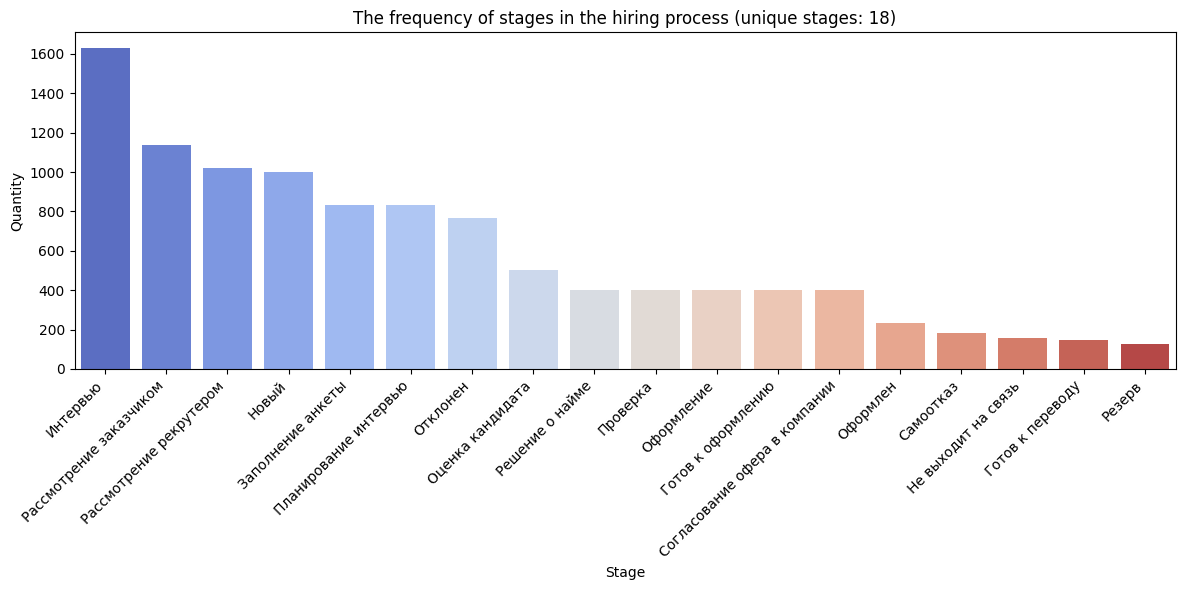

In [ ]:
stage_counts = pd.concat([hr['from'], hr['to']]).value_counts().reset_index()
stage_counts.columns = ['stage', 'count']
unique_stagesss = set(hr['from']).union(set(hr['to']))

plt.figure(figsize=(12, 6))
sns.barplot(data=stage_counts, x='stage', y='count', palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title(f'The frequency of stages in the hiring process (unique stages: {len(unique_stagesss)})')
plt.xlabel("Stage")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()


3. **Stages with the greatest delay**

<ipython-input-38-66916d835e40>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




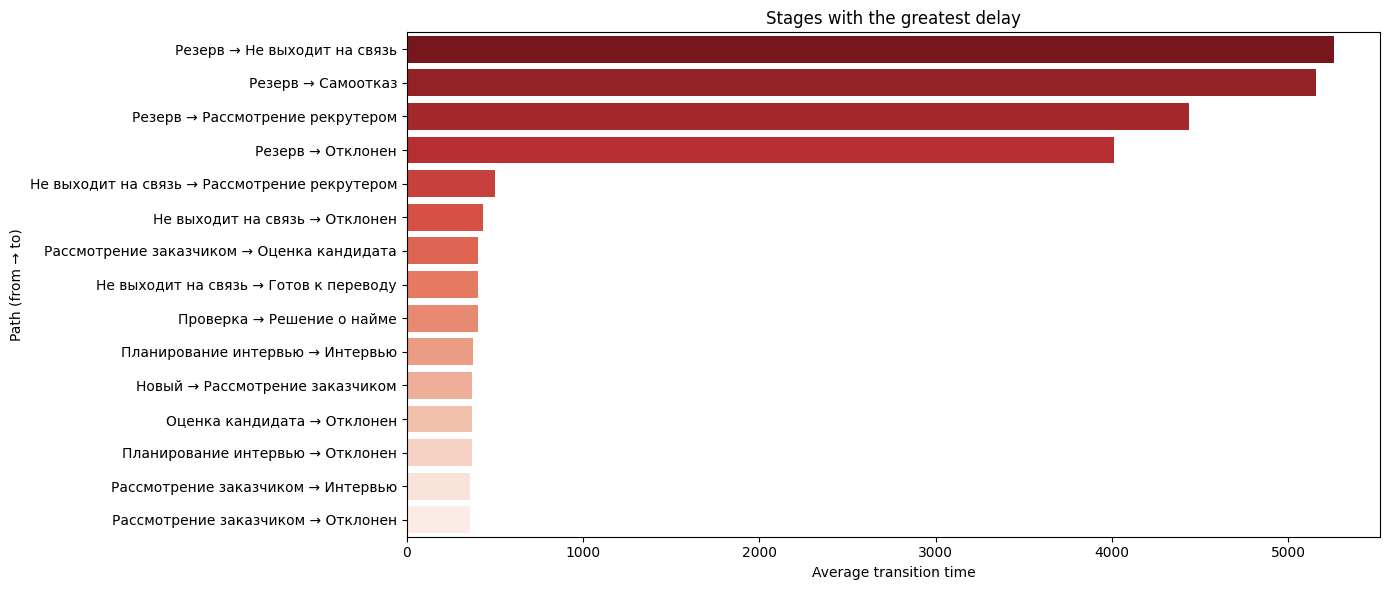

,from,to,count,mean,min,max
33,Резерв,Не выходит на связь,16,5258.338147,1068.348825,8691.681401
36,Резерв,Самоотказ,13,5157.139233,978.211292,8310.092197
35,Резерв,Рассмотрение рекрутером,13,4437.437140,1286.676130,8110.626994
34,Резерв,Отклонен,22,4013.954811,261.571178,8707.881185
11,Не выходит на связь,Рассмотрение рекрутером,3,502.510820,195.121667,713.615039
9,Не выходит на связь,Отклонен,20,432.112437,59.785586,714.900486
23,Рассмотрение заказчиком,Оценка кандидата,198,406.875587,3.531124,728.678351
8,Не выходит на связь,Готов к переводу,17,404.126746,74.941261,652.390405
20,Проверка,Решение о найме,201,404.017373,120.362841,726.206371
18,Планирование интервью,Интервью,213,374.474364,11.576970,726.085217


In [ ]:
time_analysis = hr.groupby(['from', 'to'])['time'].agg(['count', 'mean', 'min', 'max']).reset_index()
time_analysis_sorted = time_analysis.sort_values(by='mean', ascending=False).head(15)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=time_analysis_sorted,
    x='mean',
    y=time_analysis_sorted['from'] + ' → ' + time_analysis_sorted['to'],
    palette='Reds_r'
)
plt.xlabel('Average transition time')
plt.ylabel('Path (from → to)')
plt.title('Stages with the greatest delay')
plt.tight_layout()
plt.show()

time_analysis_sorted

4. Compare average time with log data

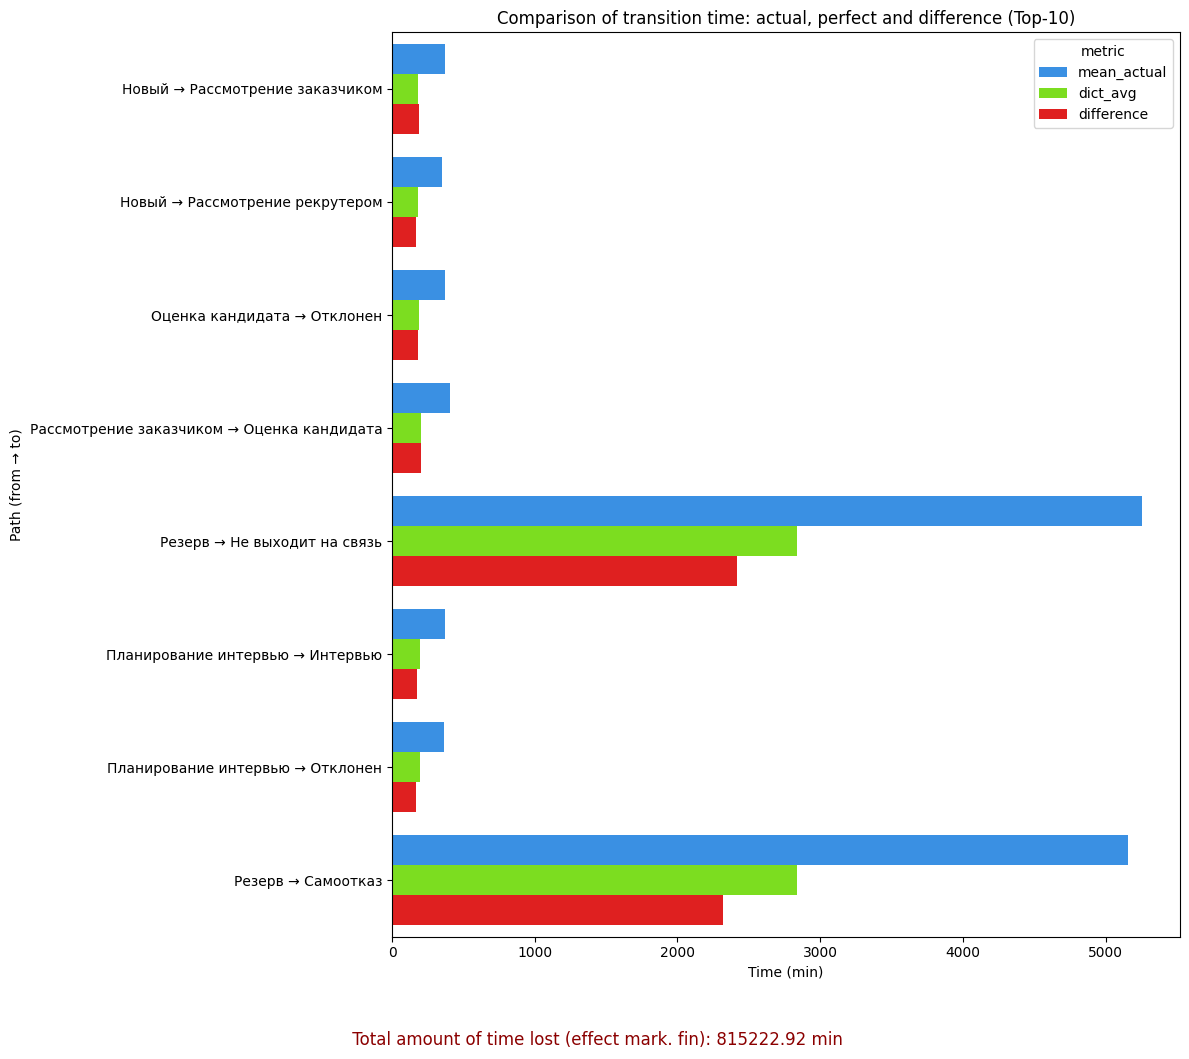

In [ ]:
actual_times = hr.groupby(['from', 'to'])['time'].mean().reset_index()
actual_times.columns = ['from', 'to', 'mean_actual']

transition_counts = hr.groupby(['from', 'to']).size().reset_index(name='count')

actual_data = pd.merge(actual_times, transition_counts, on=['from', 'to'])

dictionary_renamed = dic.rename(columns={'min': 'dict_min', 'max': 'dict_max', 'avg': 'dict_avg'})
merged_df = pd.merge(actual_data, dictionary_renamed, on=['from', 'to'], how='inner')

merged_df['difference'] = merged_df['mean_actual'] - merged_df['dict_avg']
merged_df['loss'] = merged_df['difference'] * merged_df['count']

total_loss = merged_df['loss'].sum()

top_transitions = merged_df.sort_values(by='loss', ascending=False).head(10)

melted = top_transitions.melt(
    id_vars=['from', 'to'],
    value_vars=['mean_actual', 'dict_avg', 'difference'],
    var_name='Метрика',
    value_name='Время'
)
melted['Переход'] = melted['from'] + ' → ' + melted['to']

plt.figure(figsize=(12, 10))
sns.barplot(
    data=melted,
    y='Переход',
    x='Время',
    hue='Метрика',
    palette={'mean_actual': '#1E90FF', 'dict_avg': '#7CFC00', 'difference': '#FF0000'}
)

plt.title('Comparison of transition time: actual, perfect and difference (Top-10)')
plt.xlabel('Time (min)')
plt.ylabel('Path (from → to)')
plt.legend(title='metric')

plt.figtext(0.5, -0.05, f" Total amount of time lost (effect mark. fin): {total_loss:.2f} min",
             wrap=True, horizontalalignment='center', fontsize=12, color='darkred')

plt.tight_layout()
plt.show()


3.d. Visualization of cycles and loops in the process

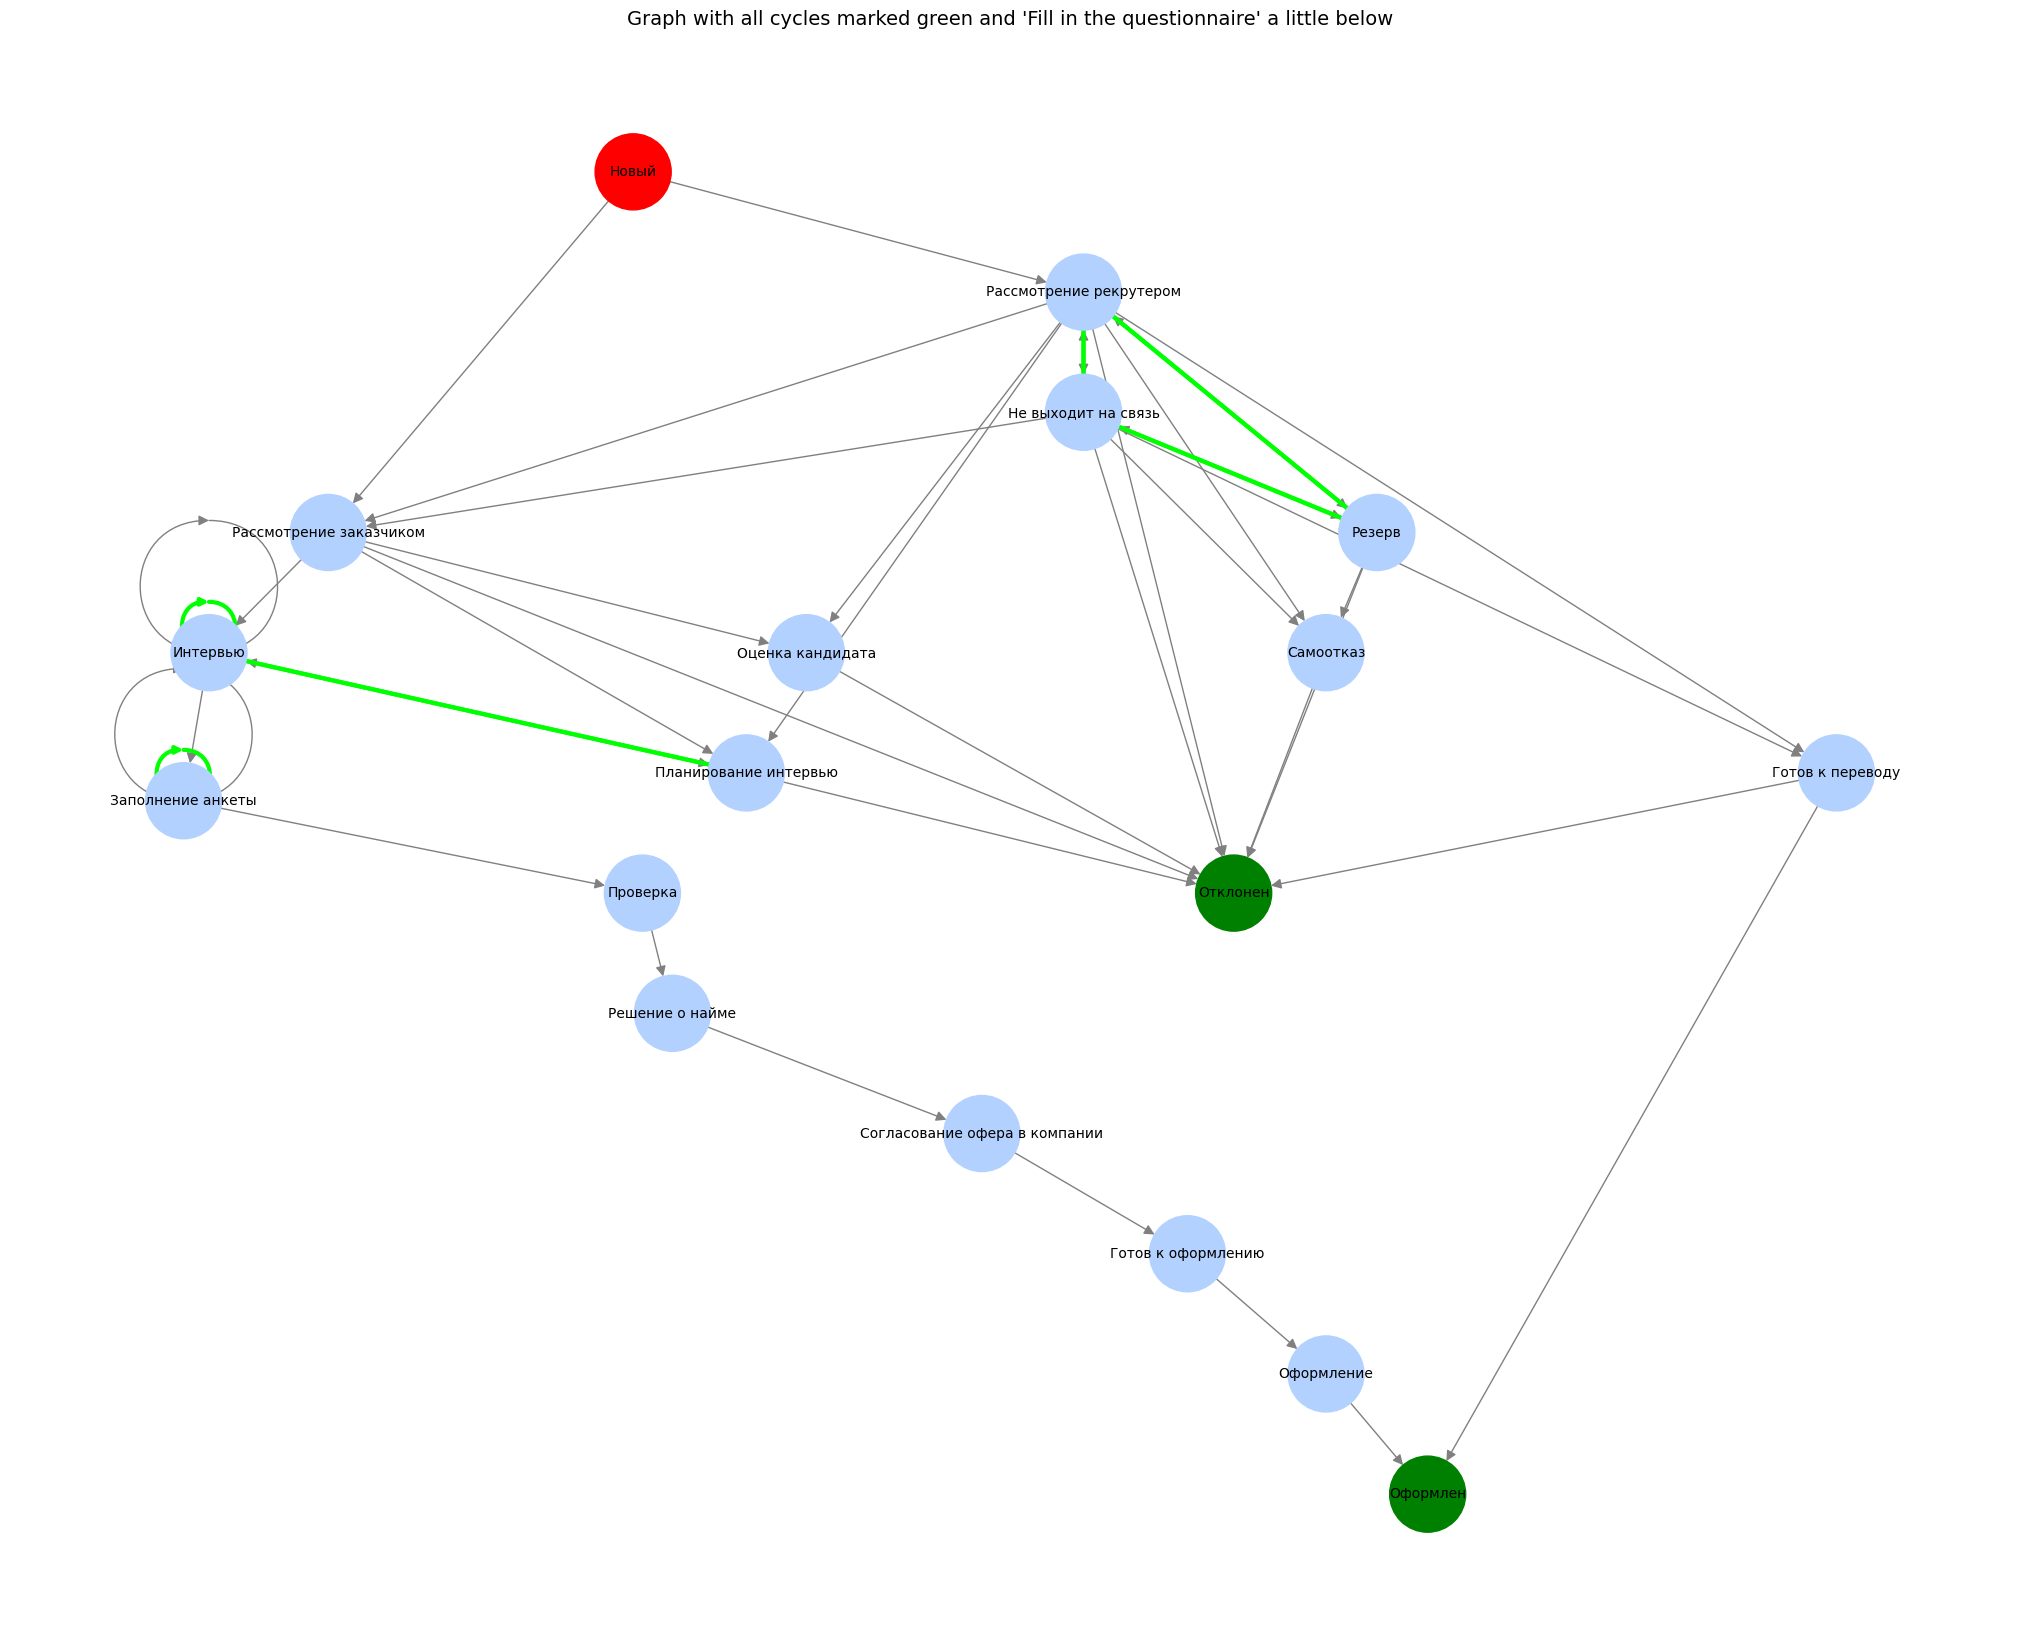

In [ ]:
G = nx.DiGraph()
for _, row in hr.iterrows():
    G.add_edge(row['from'], row['to'])

cycles = list(nx.simple_cycles(G))

node_colors = {}
for node in G.nodes:
    if node == "Новый":
        node_colors[node] = 'red'
    elif node in ["Оформлен", "Отклонен"]:
        node_colors[node] = 'green'
    else:
        node_colors[node] = '#B3D1FF'

from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(G, prog='dot')
pos_scaled = {k: (v[0]*6, v[1]*6) for k, v in pos.items()}

pos_adjusted = pos_scaled.copy()
pos_adjusted['Интервью'] = (pos_adjusted['Интервью'][0] - 100, pos_adjusted['Интервью'][1])
pos_adjusted['Заполнение анкеты'] = (pos_adjusted['Заполнение анкеты'][0] - 100, pos_adjusted['Заполнение анкеты'][1] - 100)

cycle_edges = set()
for cycle in cycles:
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        cycle_edges.add((u, v))

plt.figure(figsize=(20, 16))
nx.draw(
    G, pos_adjusted,
    with_labels=True,
    node_size=3000,
    node_color=[node_colors[node] for node in G.nodes],
    font_size=10,
    edge_color='grey',
    width=1,
    arrowsize=15
)

nx.draw_networkx_edges(G, pos_adjusted, edgelist=list(cycle_edges), edge_color='lime', width=3, arrows=True)

plt.title("Graph with all cycles marked green and 'Fill in the questionnaire' a little below", fontsize=14)
plt.axis("off")
plt.show()


3.e. Optimized process without cycles and loops

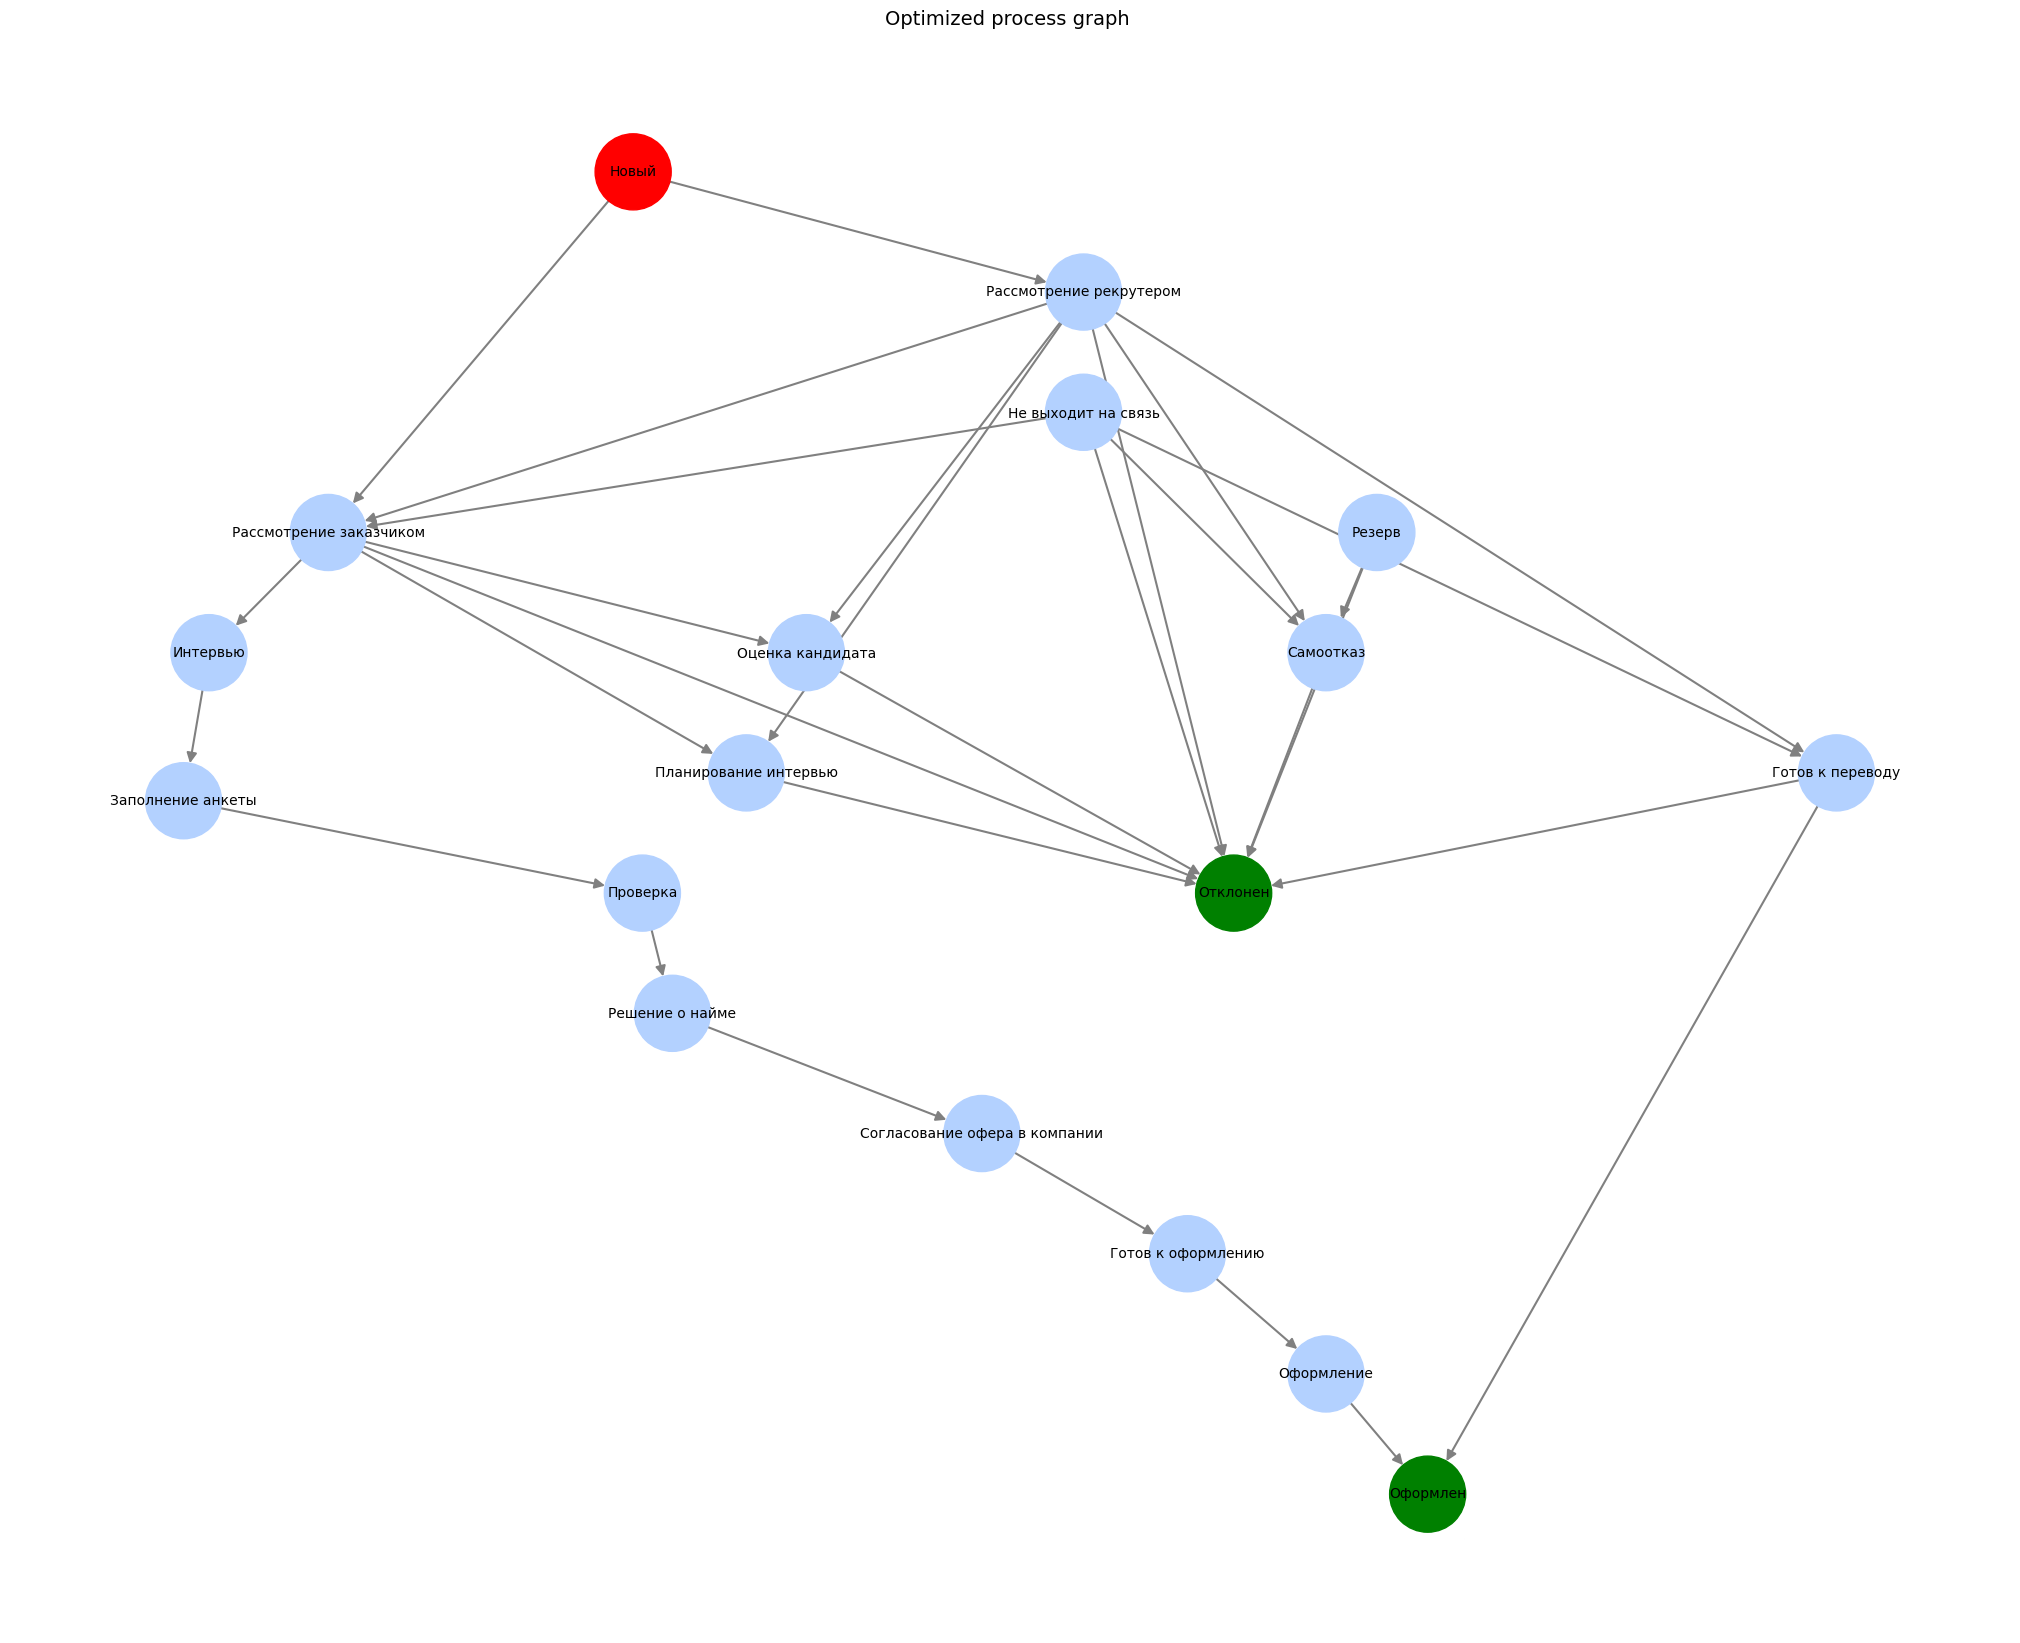

In [ ]:
G = nx.DiGraph()
for _, row in hr.iterrows():
    G.add_edge(row['from'], row['to'])
cycles = list(nx.simple_cycles(G))
node_colors = {}
for node in G.nodes:
    if node == "Новый":
        node_colors[node] = 'red'
    elif node in ["Оформлен", "Отклонен"]:
        node_colors[node] = 'green'
    else:
        node_colors[node] = '#B3D1FF'

cycle_edges = set()
for cycle in cycles:
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        cycle_edges.add((u, v))

G_no_cycles = G.copy()
G_no_cycles.remove_edges_from(cycle_edges)
self_loops = [(n, n) for n in G.nodes if G.has_edge(n, n)]
G_no_cycles.remove_edges_from(self_loops)
pos = graphviz_layout(G, prog='dot')
pos_scaled = {k: (v[0]*6, v[1]*6) for k, v in pos.items()}
pos_adjusted = pos_scaled.copy()
pos_adjusted['Интервью'] = (pos_adjusted['Интервью'][0] - 100, pos_adjusted['Интервью'][1])
pos_adjusted['Заполнение анкеты'] = (pos_adjusted['Заполнение анкеты'][0] - 100, pos_adjusted['Заполнение анкеты'][1] - 100)

plt.figure(figsize=(20, 16))
nx.draw(
    G_no_cycles, pos_adjusted,
    with_labels=True,
    node_size=3000,
    node_color=[node_colors[node] for node in G_no_cycles.nodes],
    font_size=10,
    edge_color='grey',
    width=1.5,
    arrowsize=15
)

plt.title("Optimized process graph ", fontsize=14)
plt.axis("off")
plt.show()


# Digital twin

## RL - process model

**Total amount of time in log**

In [ ]:
total_time_fact = hr.groupby('case_id')['time'].sum().sum()
print("Total amount of time in log:", total_time_fact)


Total amount of time in log: 1399346.5312736859


In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 834.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

**Model for finding the optimal path in process**

In [51]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN

transition_times_df = hr.groupby(['from', 'to'])['time'].mean().reset_index()
transition_times = {(row['from'], row['to']): row['time'] for _, row in transition_times_df.iterrows()}

graph = {}
for from_node in hr['from'].unique():
    to_nodes = hr[hr['from'] == from_node]['to'].unique().tolist()
    graph[from_node] = to_nodes

class ProcessEnv(gym.Env):
    def __init__(self, graph, transition_times, start_node="Новый", end_nodes=["Оформлен"]):
        super(ProcessEnv, self).__init__()
        all_nodes = set(hr['from']).union(set(hr['to']))
        self.node_list = list(all_nodes)
        self.node_to_idx = {node: idx for idx, node in enumerate(self.node_list)}
        self.idx_to_node = {idx: node for node, idx in self.node_to_idx.items()}
        self.graph = graph
        self.transition_times = transition_times
        self.start_node = start_node
        self.end_nodes = end_nodes
        self.current_node = start_node
        self.action_space = spaces.Discrete(len(self.node_list))
        self.observation_space = spaces.Discrete(len(self.node_list))
        self.action_map = {node: [self.node_to_idx[to] for to in self.graph.get(node, [])] for node in self.node_list}

    def reset(self, seed=None, options=None):
        self.current_node = self.start_node
        return self.node_to_idx[self.current_node], {}

    def step(self, action_idx):
        action_idx = int(action_idx)
        if action_idx not in self.action_map[self.current_node]:
            return self.node_to_idx[self.current_node], -10, True, False, {}
        next_node = self.idx_to_node[action_idx]
        reward = -self.transition_times.get((self.current_node, next_node), 10)
        reward -= 1
        reward += 3
        if next_node in self.end_nodes:
            reward += 10000
        self.current_node = next_node
        done = self.current_node in self.end_nodes
        return self.node_to_idx[self.current_node], reward, done, False, {}

    def render(self):
        print(f"Current stage: {self.current_node}")


env1 = ProcessEnv(graph, transition_times, end_nodes=["Оформлен"])
model1 = DQN("MlpPolicy", env1, verbose=1, learning_rate=0.001, buffer_size=10000)
model1.learn(total_timesteps=200000)


env2 = ProcessEnv(graph, transition_times, end_nodes=["Отклонен"])
model2 = DQN("MlpPolicy", env2, verbose=1, learning_rate=0.001, buffer_size=10000)
model2.learn(total_timesteps=200000)


obs, _ = env1.reset()
done = False
path1 = [env1.current_node]
while not done:
    action, _ = model1.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env1.step(action)
    path1.append(env1.current_node)
print("Path to Оформлен:", " → ".join(path1))


obs, _ = env2.reset()
done = False
path2 = [env2.current_node]
while not done:
    action, _ = model2.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env2.step(action)
    path2.append(env2.current_node)
print("Path to Отклонен:", " → ".join(path2))



Выходные данные были обрезаны до нескольких последних строк (5000).
|    loss             | 0.272    |
|    n_updates        | 49316    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 9.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 105532   |
|    fps              | 521      |
|    time_elapsed     | 378      |
|    total_timesteps  | 197374   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.659    |
|    n_updates        | 49318    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 9.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 105536   |
|    fps              | 521      |
|    time_elapsed     

## Financial effect

### Время оптимального пути агента от Новый до Оформлен

In [52]:
optimal_time1 = 0
for i in range(len(path1) - 1):
    from_node = path1[i]
    to_node = path1[i + 1]
    optimal_time1 += transition_times.get((from_node, to_node), 0)
print(" Time to Оформлен:", optimal_time1)


 Time to Оформлен: 505.3027740514161


### Optimal agent path time from Новый to Отклонен

In [53]:
optimal_time2 = 0
for i in range(len(path2) - 1):
    from_node = path2[i]
    to_node = path2[i + 1]
    optimal_time2 += transition_times.get((from_node, to_node), 0)
print("Path time to Отклонен:", optimal_time2)

Path time to Отклонен: 354.22025695858815


In [55]:
total_time_fact = hr['time'].sum()
print(f"Total time lost: {total_time_fact:.2f} min")

num_cases = hr['case_id'].nunique()
print(f"Number of cases: {num_cases}")

optimal_time = min(optimal_time1, optimal_time2)
print(f"Optimal instance time of the process: {optimal_time:.2f} min")

saved_time = total_time_fact - (optimal_time * num_cases)
print(f"Financial effect of digital twin: {saved_time:.2f} min")


Total time lost: 1399346.53 min
Number of cases: 1000
Optimal instance time of the process: 354.22 min
Financial effect of digital twin: 1045126.27 min
